In [73]:
# Eric Pulick HW2 CS760

In [74]:
# Import relevant packages
import numpy as np
import matplotlib.pyplot as plt

float_formatter = "{:.3f}".format
np.set_printoptions(formatter={'float_kind':float_formatter})

In [75]:
# Class definition for tree
class Tree():
    def __init__(self,fp,input_data=None):
        # Import chosen dataset from given filepath fp
        if input_data is not None:
            data=input_data
        else:
            data = self.import_dataset(fp)
        self.data=data
        self.root = Node(data,is_root=True)

    # Wrap around numpy loadtxt function
    def import_dataset(self,fp):
        data = np.loadtxt(fp)
        return data
    
    # Using the node display functions, begin a recursive tree print
    def print_tree(self):
        print("ROOT NODE")
        self.root.display()

    def make_pred(self,test):
        observations = test.shape[0]
        errors=0
        for i in test:
            #print("Data point: ",i[0:3])
            pred = self.root.eval_pred(i)
            #print(pred)
            if pred!=i[2]:
                #print("ERROR!")
                errors+=1
        return errors
    
    def count_nodes(self):
        total = self.root.count_nodes()
        return total
    
    def draw_lines(self,ax):
        xmin = self.data[:,0].min()
        xmax = self.data[:,0].max()
        ymin = self.data[:,1].min()
        ymax = self.data[:,1].max()
        self.root.lines(ax,xmin,xmax,ymin,ymax)

# Class definition for a node
class Node():
    def __init__(self,data,depth=None,is_root=False):
        # Initialize variables based on inputs/defaults

        # Define if the node is a root node
        self.is_root = is_root
        if self.is_root:
            self.depth=0
        else:
            self.depth=depth+1
        # Attribute for the (potentially filtered) dataset at this node
        self.data = data
        # Default variable values
        self.splits_dict = None
        self.is_leaf = True
        self.split_feat = None
        self.split_val = None
        self.left = None
        self.right = None
        self.pred = None

        # If the dataset is not empty, proceed
        if data.shape[0]!=0:
            
            # Dictionary for storing the information gain ratios for splits along either feature
            # splits[0] contains information for splits on feature 0, splits[1] for splits on feature 1
            splits_dict ={}

            # Loop over both features
            for i in range(0,2):
                # Calculate the possible splits and the information gain ratios
                possible_splits,ratios = self.calc_feature_splits(data,i)
                # Group the splits with their respective ratios
                stacked_information = np.stack((possible_splits,ratios),axis=1)
                # Store the information in the dictionary
                splits_dict[i]=stacked_information
            # Max values for information gain ratio along each feature
            f0_max = splits_dict[0][np.argmax(splits_dict[0][:,1]),:]
            f1_max = splits_dict[1][np.argmax(splits_dict[1][:,1]),:]

            # If there is something to be gained from splitting, proceed
            if f0_max[1]>0 or f1_max[1]>0:
                # Node can no longer be a leaf node
                self.is_leaf=False
                # Greedily select the split feature and split value
                if f0_max[1]>=f1_max[1]:
                    self.split_feat=0
                    self.split_val=f0_max[0]
                else:
                    self.split_feat=1
                    self.split_val=f1_max[0]
            # Store the dictionary for use elsewhere
            self.splits_dict=splits_dict

        # If the node is not a leaf, it needs to trigger further node creation
        if not self.is_leaf:    
            # Data satisfying each side of the proposition
            left_data = self.data[self.data[:,self.split_feat]>=self.split_val]
            right_data = self.data[self.data[:,self.split_feat]<self.split_val]
            
            # Create new nodes
            self.left = Node(left_data,self.depth)
            self.right = Node(right_data,self.depth)
            return
        else:
            # If the node is a leaf, establish a prediction attribute for the node
            self.make_pred()

    # Calculate the information gain ratios associated with all possible splits along a given feature            
    def calc_feature_splits(self,ds,feat):
        # Gather general information
        observation_count = ds.shape[0]
        total_positives = np.sum(ds[:,2])
        # Calculate entropy at the node
        base_entropy = self.calc_entropy(total_positives/observation_count)
        # Sort the data to gather ordered candidate splits
        sorted_data = ds[ds[:,feat].argsort()]
        splits = sorted_data[:,feat]
        # Preallocate vector for information gain ratios
        info_gain_ratios = np.zeros(observation_count)

        # If the base entropy is already zero, no need to proceed with calculations
        # Otherwise evaluate information gain for each split value
        if base_entropy!=0:
            #cum_sums = np.sum(sorted_data[:,2])
            # Loop over each possible split
            for idx,split in enumerate(splits):

                # Portion of the dataset on the 'left' side of candidate split
                left = ds[ds[:,feat]>=split]
                left_count = left.shape[0]
                left_positives = np.sum(left[:,2],axis=0)
                # Portion of the dataset on the 'right' side of candidate split
                right = ds[ds[:,feat]<split]
                right_count = right.shape[0]
                right_positives = np.sum(right[:,2],axis=0)
                
                # Since propositions are oriented as >= check to see if chosen split creates empty < side
                if right_count==0:
                    # Split is meaningless, provides no information gain
                    info_gain_ratio = 0
                else:
                    # So long as the class probabilities aren't 0/1, use log calculation for the entropy
                    left_entropy = self.calc_entropy(left_positives/left_count)
                    right_entropy = self.calc_entropy(right_positives/right_count)

                    # Gather calculations into conditional entropy and gain ratio
                    conditional_entropy = left_count/observation_count*left_entropy + right_count/observation_count * right_entropy
                    split_entropy = self.calc_entropy(left_count/observation_count)
                    info_gain_ratio = (base_entropy-conditional_entropy)/split_entropy
                # Log the result
                info_gain_ratios[idx] = info_gain_ratio
        return splits, info_gain_ratios

    # Simple entropy calculation for prediction values 
    def calc_entropy(self,frac):
        if frac not in [0,1]:
            return (-1*frac*np.log2(frac)-(1-frac)*np.log2(1-frac))
        else:
            return 0
    
    # Create tree representation mimicking structure from sklearn
    def display(self):
        if self.is_leaf:
            print("|", end="")
            for i in range(self.depth):
                print("   |",end="")
            print("--- terminal, predict {}".format(self.pred))
        else:
            print("|",end="")
            for i in range(self.depth):
                print("   |",end="")
            print("--- Feature {} >= {}".format(str(self.split_feat),str(self.split_val)))
            self.left.display()
            print("|",end="")
            for i in range(self.depth):
                print("   |",end="")
            print("--- Feature {} < {}".format(str(self.split_feat),str(self.split_val)))
            self.right.display()

    # Define the prediction attribute for a leaf node
    def make_pred(self):
        # Total observations, total '1' count, total '0' count
        observations = self.data.shape[0]
        ones = np.sum(self.data[:,2])
        zeros = observations-ones
        # If there are more 1's than 0's predict 1 (ties predict 1 as well)
        if ones>=zeros:
            self.pred = 1
        # Otherwise predict 0
        else:
            self.pred = 0

    def eval_pred(self,datapoint):
        if self.is_leaf:
            return self.pred
        else:
            is_left = datapoint[self.split_feat]>=self.split_val
            if is_left:
                return self.left.eval_pred(datapoint)
            else:
                return self.right.eval_pred(datapoint)
            
    def count_nodes(self):
        if self.is_leaf:
            return 1
        else:
            return self.left.count_nodes()+self.right.count_nodes()+1
    
    def lines(self,ax,minx,maxx,miny,maxy):
        if not self.is_leaf:
            if self.split_feat==0:
                ax.vlines(x=self.split_val, ymin=miny,ymax=maxy,color='k', ls='--', lw=4)
                self.left.lines(ax,self.split_val,maxx,miny,maxy)
                self.right.lines(ax,minx,self.split_val,miny,maxy)
            else:
                ax.hlines(y=self.split_val, xmin=minx,xmax=maxx,color='k', ls='--', lw=4)
                self.left.lines(ax,minx,maxx,self.split_val,maxy)
                self.right.lines(ax,minx,maxx,miny,self.split_val)
            

In [76]:
# Test the code
data_path = "data/D1.txt"
test = Tree(data_path)
test.print_tree()

ROOT NODE
|--- Feature 1 >= 0.201829
|   |--- terminal, predict 1
|--- Feature 1 < 0.201829
|   |--- terminal, predict 0


ROOT NODE
|--- terminal, predict 1
[[-1.000 1.000 0.000]
 [-1.000 -1.000 1.000]
 [1.000 1.000 1.000]
 [1.000 -1.000 0.000]]


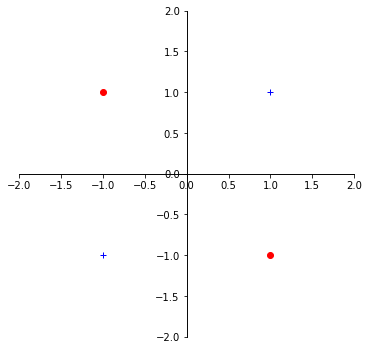

In [77]:
# Question 2-2
data_path = "data/2_2.txt"
stubborn = Tree(data_path)
stubborn.print_tree()
stubborn_data= stubborn.root.data
s0 = stubborn_data[stubborn_data[:,2]==0]
s1 = stubborn_data[stubborn_data[:,2]==1]
print(stubborn_data)

plt.figure(figsize=(6,6))
plt.plot(s0[:,0],s0[:,1],'ro')
plt.plot(s1[:,0],s1[:,1],'b+')
ax =plt.gca()
ax.set_xlim(-2,2)
ax.set_ylim(-2,2)
plt.gca().spines[:].set_position('center')


In [78]:
#2-3
data_path_23 = "data/Druns.txt"
data_23 = Tree(data_path_23)
f0 = data_23.root.splits_dict[0]
f1 = data_23.root.splits_dict[1]
print() 
print("Root splits on feature 0: (split value, information gain ratio)\n",f0[np.unique(f0[:,0],return_index=True)[1]])
print()
print("Root splits on feature 1: (split value, information gain ratio)\n",f1[np.unique(f1[:,0],return_index=True)[1]])
print()
data_23.print_tree()


Root splits on feature 0: (split value, information gain ratio)
 [[0.000 0.000]
 [0.100 0.101]]

Root splits on feature 1: (split value, information gain ratio)
 [[-2.000 0.000]
 [-1.000 0.101]
 [0.000 0.056]
 [1.000 0.006]
 [2.000 0.001]
 [3.000 0.016]
 [4.000 0.050]
 [5.000 0.111]
 [6.000 0.236]
 [7.000 0.056]
 [8.000 0.430]]

ROOT NODE
|--- Feature 1 >= 8.0
|   |--- terminal, predict 1
|--- Feature 1 < 8.0
|   |--- Feature 1 >= 0.0
|   |   |--- Feature 1 >= 6.0
|   |   |   |--- Feature 1 >= 7.0
|   |   |   |   |--- terminal, predict 0
|   |   |   |--- Feature 1 < 7.0
|   |   |   |   |--- terminal, predict 1
|   |   |--- Feature 1 < 6.0
|   |   |   |--- terminal, predict 0
|   |--- Feature 1 < 0.0
|   |   |--- Feature 0 >= 0.1
|   |   |   |--- terminal, predict 0
|   |   |--- Feature 0 < 0.1
|   |   |   |--- terminal, predict 1


In [79]:
#2-4 
data_path_24 = "data/D3leaves.txt"
data_24 = Tree(data_path_24)
data_24.print_tree()

ROOT NODE
|--- Feature 0 >= 10.0
|   |--- terminal, predict 1
|--- Feature 0 < 10.0
|   |--- Feature 1 >= 3.0
|   |   |--- terminal, predict 1
|   |--- Feature 1 < 3.0
|   |   |--- terminal, predict 0


In [80]:
#2-5a
data_path_25 = "data/D1.txt"
data_25 = Tree(data_path_25)
data_25.print_tree()

ROOT NODE
|--- Feature 1 >= 0.201829
|   |--- terminal, predict 1
|--- Feature 1 < 0.201829
|   |--- terminal, predict 0


In [81]:
#2-5c
data_path_25c = "data/D2.txt"
data_25c = Tree(data_path_25c)
data_25c.print_tree()

ROOT NODE
|--- Feature 0 >= 0.533076
|   |--- Feature 1 >= 0.228007
|   |   |--- Feature 1 >= 0.424906
|   |   |   |--- terminal, predict 1
|   |   |--- Feature 1 < 0.424906
|   |   |   |--- Feature 0 >= 0.708127
|   |   |   |   |--- terminal, predict 1
|   |   |   |--- Feature 0 < 0.708127
|   |   |   |   |--- Feature 1 >= 0.32625
|   |   |   |   |   |--- Feature 0 >= 0.595471
|   |   |   |   |   |   |--- Feature 0 >= 0.646007
|   |   |   |   |   |   |   |--- terminal, predict 1
|   |   |   |   |   |   |--- Feature 0 < 0.646007
|   |   |   |   |   |   |   |--- Feature 1 >= 0.403494
|   |   |   |   |   |   |   |   |--- terminal, predict 1
|   |   |   |   |   |   |   |--- Feature 1 < 0.403494
|   |   |   |   |   |   |   |   |--- terminal, predict 0
|   |   |   |   |   |--- Feature 0 < 0.595471
|   |   |   |   |   |   |--- terminal, predict 0
|   |   |   |   |--- Feature 1 < 0.32625
|   |   |   |   |   |--- terminal, predict 0
|   |--- Feature 1 < 0.228007
|   |   |--- Feature 0 >= 0.887

ROOT NODE
|--- Feature 1 >= 0.201829
|   |--- terminal, predict 1
|--- Feature 1 < 0.201829
|   |--- terminal, predict 0


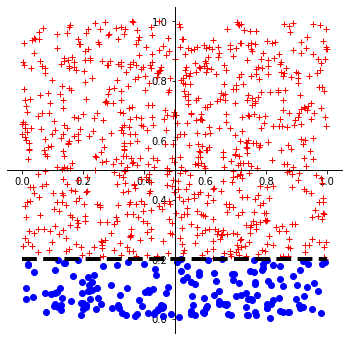

In [82]:
#2-6
data_path1 = "data/D1.txt"
data_path2 = "data/D2.txt"
d1 = Tree(data_path1)
d2 = Tree(data_path2)
d1d = d1.root.data
d1d1 = d1d[d1d[:,2]==1]
d1d0 = d1d[d1d[:,2]==0]
d2d = d2.root.data
d2d1 = d2d[d2d[:,2]==1]
d2d0 = d2d[d2d[:,2]==0]

d1.print_tree()
plt.figure(figsize=(6,6))
plt.plot(d1d1[:,0],d1d1[:,1],'r+')
plt.plot(d1d0[:,0],d1d0[:,1],'bo')
#plt.plot(d2d[:,0],d2d[:,1],'b+')
ax =plt.gca()
#ax.set_xlim(-2,2)
#ax.set_ylim(-2,2)
d1.draw_lines(ax)
plt.gca().spines[:].set_position('center')
plt.savefig('d1_data_vis.png')

ROOT NODE
|--- Feature 0 >= 0.533076
|   |--- Feature 1 >= 0.228007
|   |   |--- Feature 1 >= 0.424906
|   |   |   |--- terminal, predict 1
|   |   |--- Feature 1 < 0.424906
|   |   |   |--- Feature 0 >= 0.708127
|   |   |   |   |--- terminal, predict 1
|   |   |   |--- Feature 0 < 0.708127
|   |   |   |   |--- Feature 1 >= 0.32625
|   |   |   |   |   |--- Feature 0 >= 0.595471
|   |   |   |   |   |   |--- Feature 0 >= 0.646007
|   |   |   |   |   |   |   |--- terminal, predict 1
|   |   |   |   |   |   |--- Feature 0 < 0.646007
|   |   |   |   |   |   |   |--- Feature 1 >= 0.403494
|   |   |   |   |   |   |   |   |--- terminal, predict 1
|   |   |   |   |   |   |   |--- Feature 1 < 0.403494
|   |   |   |   |   |   |   |   |--- terminal, predict 0
|   |   |   |   |   |--- Feature 0 < 0.595471
|   |   |   |   |   |   |--- terminal, predict 0
|   |   |   |   |--- Feature 1 < 0.32625
|   |   |   |   |   |--- terminal, predict 0
|   |--- Feature 1 < 0.228007
|   |   |--- Feature 0 >= 0.887

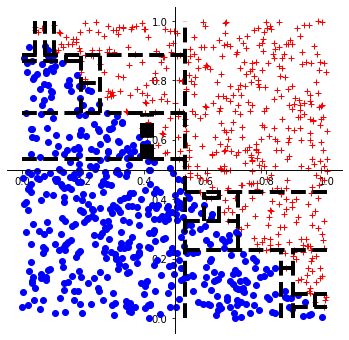

In [83]:
d2.print_tree()
plt.figure(figsize=(6,6))
plt.plot(d2d1[:,0],d2d1[:,1],'r+')
plt.plot(d2d0[:,0],d2d0[:,1],'bo')
#plt.plot(d2d[:,0],d2d[:,1],'b+')
ax =plt.gca()
#ax.set_xlim(-2,2)
#ax.set_ylim(-2,2)
d2.draw_lines(ax)
plt.gca().spines[:].set_position('center')
plt.savefig('d2_data_vis.png')

In [84]:
#2-7
rng = np.random.default_rng()
ordering = rng.permutation(10000)
full_data = np.loadtxt("data/Dbig.txt")
stacked_data = np.stack((full_data[:,0],full_data[:,1],full_data[:,2],ordering),axis=1)
randomized_data = stacked_data[stacked_data[:,3].argsort()]

train = randomized_data[0:8192,:]
test = randomized_data[8192:,:]
d32 = train[0:32,:]
d128 = train[0:128,:]
d512 = train[0:512,:]
d2048 = train[0:2048,:]

d32t = Tree("",d32)
d128t = Tree("",d128)
d512t = Tree("",d512)
d2048t = Tree("",d2048)
d8192t = Tree("",train)


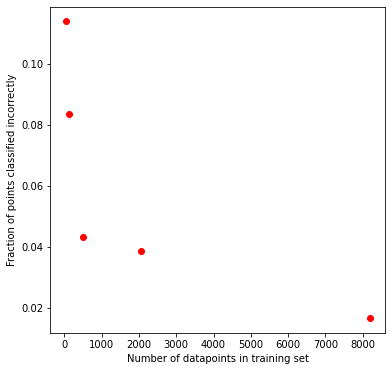

In [85]:
n = [32, 128, 512, 2048, 8192]
count_test = test.shape[0]
err = [d32t.make_pred(test)/count_test,
       d128t.make_pred(test)/count_test,
       d512t.make_pred(test)/count_test,
       d2048t.make_pred(test)/count_test,
       d8192t.make_pred(test)/count_test]

plt.figure(figsize=(6,6))
plt.plot(n,err,'ro')
ax =plt.gca()
ax.set_xlabel("Number of datapoints in training set")
ax.set_ylabel("Fraction of points classified incorrectly")
plt.savefig("d_err_plots.png")


In [86]:
node_count = []
for tree in [d32t, d128t, d512t, d2048t, d8192t]:
    node_count.append(tree.count_nodes())

info=np.stack((n,node_count,err),axis=1)
print("(Training count, Node count, Fraction misclassified)\n",info)

(Training count, Node count, Fraction misclassified)
 [[32.000 9.000 0.114]
 [128.000 17.000 0.084]
 [512.000 53.000 0.043]
 [2048.000 143.000 0.039]
 [8192.000 251.000 0.017]]


ROOT NODE
|--- Feature 1 >= -0.644335
|   |--- Feature 1 >= 1.196545
|   |   |--- terminal, predict 1
|   |--- Feature 1 < 1.196545
|   |   |--- Feature 0 >= 1.174588
|   |   |   |--- terminal, predict 1
|   |   |--- Feature 0 < 1.174588
|   |   |   |--- Feature 0 >= -0.775965
|   |   |   |   |--- terminal, predict 0
|   |   |   |--- Feature 0 < -0.775965
|   |   |   |   |--- terminal, predict 1
|--- Feature 1 < -0.644335
|   |--- terminal, predict 1


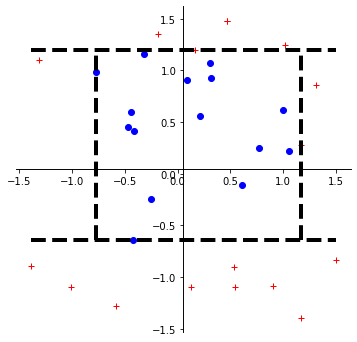

In [87]:
d32t.print_tree()
plt.figure(figsize=(6,6))
plt.plot(d32[d32[:,2]==1][:,0],d32[d32[:,2]==1][:,1],'r+')
plt.plot(d32[d32[:,2]==0][:,0],d32[d32[:,2]==0][:,1],'bo')
#plt.plot(d2d[:,0],d2d[:,1],'b+')
ax =plt.gca()
#ax.set_xlim(-2,2)
#ax.set_ylim(-2,2)
d32t.draw_lines(ax)
plt.gca().spines[:].set_position('center')
plt.savefig("32.png")

ROOT NODE
|--- Feature 1 >= -0.770909
|   |--- Feature 1 >= 1.181827
|   |   |--- terminal, predict 1
|   |--- Feature 1 < 1.181827
|   |   |--- Feature 0 >= -1.105338
|   |   |   |--- Feature 0 >= 1.134701
|   |   |   |   |--- terminal, predict 1
|   |   |   |--- Feature 0 < 1.134701
|   |   |   |   |--- Feature 1 >= -0.644335
|   |   |   |   |   |--- Feature 1 >= -0.318475
|   |   |   |   |   |   |--- terminal, predict 0
|   |   |   |   |   |--- Feature 1 < -0.318475
|   |   |   |   |   |   |--- Feature 0 >= -0.418624
|   |   |   |   |   |   |   |--- terminal, predict 0
|   |   |   |   |   |   |--- Feature 0 < -0.418624
|   |   |   |   |   |   |   |--- terminal, predict 1
|   |   |   |   |--- Feature 1 < -0.644335
|   |   |   |   |   |--- Feature 0 >= -0.062433
|   |   |   |   |   |   |--- terminal, predict 0
|   |   |   |   |   |--- Feature 0 < -0.062433
|   |   |   |   |   |   |--- terminal, predict 1
|   |   |--- Feature 0 < -1.105338
|   |   |   |--- terminal, predict 1
|--- Feat

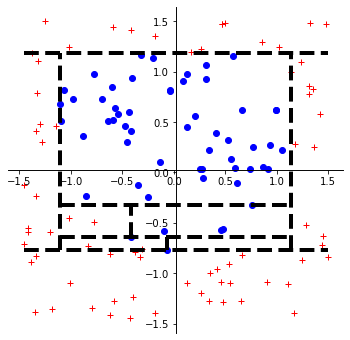

In [88]:
d128t.print_tree()
cur_tree = d128
plt.figure(figsize=(6,6))
plt.plot(cur_tree[cur_tree[:,2]==1][:,0],cur_tree[cur_tree[:,2]==1][:,1],'r+')
plt.plot(cur_tree[cur_tree[:,2]==0][:,0],cur_tree[cur_tree[:,2]==0][:,1],'bo')
#plt.plot(d2d[:,0],d2d[:,1],'b+')
ax =plt.gca()
#ax.set_xlim(-2,2)
#ax.set_ylim(-2,2)
d128t.draw_lines(ax)
plt.gca().spines[:].set_position('center')
plt.savefig("128.png")

ROOT NODE
|--- Feature 1 >= -0.87217
|   |--- Feature 1 >= 1.181827
|   |   |--- terminal, predict 1
|   |--- Feature 1 < 1.181827
|   |   |--- Feature 0 >= -1.138432
|   |   |   |--- Feature 0 >= 1.134701
|   |   |   |   |--- terminal, predict 1
|   |   |   |--- Feature 0 < 1.134701
|   |   |   |   |--- Feature 1 >= -0.34417
|   |   |   |   |   |--- Feature 0 >= 1.067025
|   |   |   |   |   |   |--- Feature 0 >= 1.123275
|   |   |   |   |   |   |   |--- terminal, predict 0
|   |   |   |   |   |   |--- Feature 0 < 1.123275
|   |   |   |   |   |   |   |--- terminal, predict 1
|   |   |   |   |   |--- Feature 0 < 1.067025
|   |   |   |   |   |   |--- Feature 1 >= 1.161678
|   |   |   |   |   |   |   |--- Feature 0 >= 0.920815
|   |   |   |   |   |   |   |   |--- terminal, predict 1
|   |   |   |   |   |   |   |--- Feature 0 < 0.920815
|   |   |   |   |   |   |   |   |--- terminal, predict 0
|   |   |   |   |   |   |--- Feature 1 < 1.161678
|   |   |   |   |   |   |   |--- Feature 0 >= -0

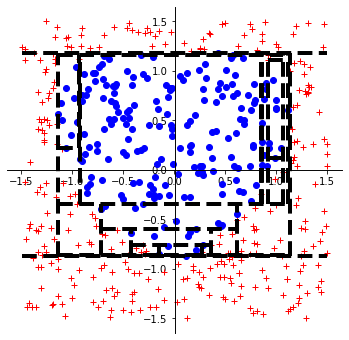

In [89]:
d512t.print_tree()
cur_tree = d512
plt.figure(figsize=(6,6))
plt.plot(cur_tree[cur_tree[:,2]==1][:,0],cur_tree[cur_tree[:,2]==1][:,1],'r+')
plt.plot(cur_tree[cur_tree[:,2]==0][:,0],cur_tree[cur_tree[:,2]==0][:,1],'bo')
#plt.plot(d2d[:,0],d2d[:,1],'b+')
ax =plt.gca()
#ax.set_xlim(-2,2)
#ax.set_ylim(-2,2)
d512t.draw_lines(ax)
plt.gca().spines[:].set_position('center')
plt.savefig("512.png")

ROOT NODE
|--- Feature 1 >= -0.87349
|   |--- Feature 1 >= 1.230285
|   |   |--- terminal, predict 1
|   |--- Feature 1 < 1.230285
|   |   |--- Feature 0 >= 1.126597
|   |   |   |--- terminal, predict 1
|   |   |--- Feature 0 < 1.126597
|   |   |   |--- Feature 0 >= -1.138432
|   |   |   |   |--- Feature 1 >= -0.698929
|   |   |   |   |   |--- Feature 0 >= -1.068019
|   |   |   |   |   |   |--- Feature 0 >= 1.000703
|   |   |   |   |   |   |   |--- Feature 1 >= 0.205093
|   |   |   |   |   |   |   |   |--- Feature 1 >= 0.786355
|   |   |   |   |   |   |   |   |   |--- Feature 0 >= 1.072832
|   |   |   |   |   |   |   |   |   |   |--- terminal, predict 1
|   |   |   |   |   |   |   |   |   |--- Feature 0 < 1.072832
|   |   |   |   |   |   |   |   |   |   |--- Feature 0 >= 1.036958
|   |   |   |   |   |   |   |   |   |   |   |--- terminal, predict 0
|   |   |   |   |   |   |   |   |   |   |--- Feature 0 < 1.036958
|   |   |   |   |   |   |   |   |   |   |   |--- terminal, predict 1
|   |

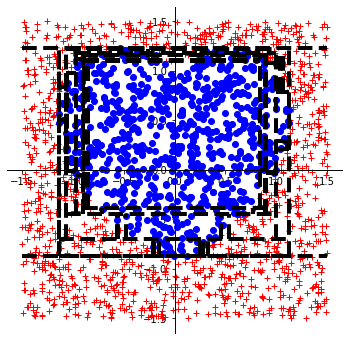

In [90]:
d2048t.print_tree()
cur_tree = d2048
plt.figure(figsize=(6,6))
plt.plot(cur_tree[cur_tree[:,2]==1][:,0],cur_tree[cur_tree[:,2]==1][:,1],'r+')
plt.plot(cur_tree[cur_tree[:,2]==0][:,0],cur_tree[cur_tree[:,2]==0][:,1],'bo')
#plt.plot(d2d[:,0],d2d[:,1],'b+')
ax =plt.gca()
#ax.set_xlim(-2,2)
#ax.set_ylim(-2,2)
d2048t.draw_lines(ax)
plt.gca().spines[:].set_position('center')
plt.savefig("2048.png")

ROOT NODE
|--- Feature 1 >= -0.856344
|   |--- Feature 0 >= 1.135791
|   |   |--- terminal, predict 1
|   |--- Feature 0 < 1.135791
|   |   |--- Feature 0 >= -1.138432
|   |   |   |--- Feature 1 >= 1.232245
|   |   |   |   |--- terminal, predict 1
|   |   |   |--- Feature 1 < 1.232245
|   |   |   |   |--- Feature 1 >= -0.686861
|   |   |   |   |   |--- Feature 0 >= -1.109935
|   |   |   |   |   |   |--- Feature 0 >= 1.061254
|   |   |   |   |   |   |   |--- Feature 1 >= 0.165721
|   |   |   |   |   |   |   |   |--- Feature 1 >= 0.825572
|   |   |   |   |   |   |   |   |   |--- terminal, predict 1
|   |   |   |   |   |   |   |   |--- Feature 1 < 0.825572
|   |   |   |   |   |   |   |   |   |--- Feature 1 >= 0.285577
|   |   |   |   |   |   |   |   |   |   |--- Feature 1 >= 0.786355
|   |   |   |   |   |   |   |   |   |   |   |--- Feature 0 >= 1.106388
|   |   |   |   |   |   |   |   |   |   |   |   |--- terminal, predict 1
|   |   |   |   |   |   |   |   |   |   |   |--- Feature 0 < 1.1

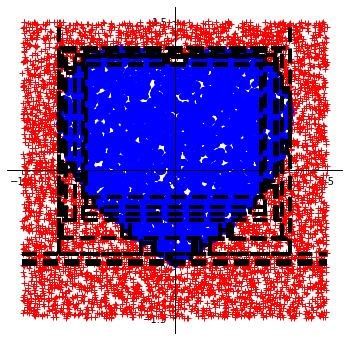

In [91]:
d8192t.print_tree()
cur_tree = train
plt.figure(figsize=(6,6))
plt.plot(cur_tree[cur_tree[:,2]==1][:,0],cur_tree[cur_tree[:,2]==1][:,1],'r+')
plt.plot(cur_tree[cur_tree[:,2]==0][:,0],cur_tree[cur_tree[:,2]==0][:,1],'bo')
#plt.plot(d2d[:,0],d2d[:,1],'b+')
ax =plt.gca()
#ax.set_xlim(-2,2)
#ax.set_ylim(-2,2)
d8192t.draw_lines(ax)
plt.gca().spines[:].set_position('center')
plt.savefig("8192.png")

(Training count, Node count, Fraction misclassified)
 [[32.000 5.000 0.114]
 [128.000 11.000 0.084]
 [512.000 25.000 0.043]
 [2048.000 63.000 0.039]
 [8192.000 119.000 0.017]]


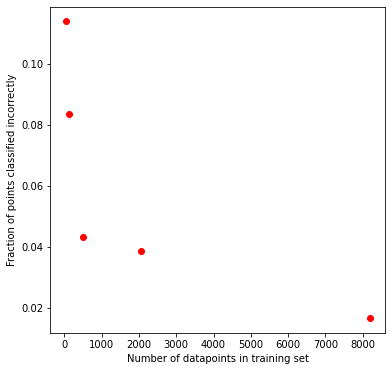

In [92]:
#3
from sklearn.tree import DecisionTreeClassifier

n_leaves = []
sk_err = []
for data in [d32, d128, d512, d2048, train]:
    tree = DecisionTreeClassifier()
    tree.fit(data[:,0:2],data[:,2])
    n_leaves.append(tree.get_n_leaves())
    sk_err.append(1-tree.score(test[:,0:2],test[:,2]))

plt.figure(figsize=(6,6))
plt.plot(n,err,'ro')
ax =plt.gca()
ax.set_xlabel("Number of datapoints in training set")
ax.set_ylabel("Fraction of points classified incorrectly")
plt.savefig("sk_d_err_plot.png")

info=np.stack((n,n_leaves,err),axis=1)
print("(Training count, Node count, Fraction misclassified)\n",info)

In [125]:
#4
from scipy.interpolate import lagrange
from numpy.polynomial.polynomial import Polynomial
from sklearn.metrics import mean_squared_error
mult = 1
train_x = rng.uniform(0,mult*2*np.pi,100)
test_x = rng.uniform(0,mult*2*np.pi,100)

train_y = np.sin(train_x)
test_y = np.sin(test_x)

In [143]:
idx = rng.permutation(100)
sd = 1

for train_size in [5,10,25,100]:
    if sd is not None:
        noise = rng.normal(0,sd,100)
        updated_x = train_x + noise
    else:
        updated_x = train_x
    train_idx = idx[0:train_size]
    poly = lagrange(updated_x[train_idx], train_y[train_idx])
    train_mse = mean_squared_error(train_y[train_idx],Polynomial(poly.coef[::-1])(updated_x[train_idx]))
    test_mse = mean_squared_error(test_y,Polynomial(poly.coef[::-1])(test_x))
    print(train_size, np.format_float_scientific(train_mse,precision=2), np.format_float_scientific(test_mse,precision=2))

    if (train_size==10 or train_size==100) and sd==None:
        poly_x = np.linspace(0,mult*2*np.pi,1000)
        plt.figure(figsize=(6,6))
        plt.plot(train_x,train_y,'ro')
        plt.plot(poly_x, Polynomial(poly.coef[::-1])(poly_x), label='Polynomial')
        ax =plt.gca()
        ax.set_xlabel("X")
        ax.set_ylim(-2,2)
        ax.set_ylabel("Y")
        if train_size==10:
            plt.savefig("10.png")
        else:
            plt.savefig("100.png")

5 1.53e-24 5.37e+04
10 4.74e-17 3.22e+06
25 1.55e+17 6.67e+21
100 1.03e+144 1.03e+131


In [95]:
for sd in [.01,.1]:
    